Starting the Ollama server with Docker:

`docker run -d --restart=unless-stopped --gpus=all -v /data2/ollama/cache:/root/.ollama -p 11434:11434 --name ollama-gpu -e OLLAMA_NUM_PARALLEL=4 -e OLLAMA_MAX_LOADED_MODELS=4 ollama/ollama`

# Are the LLMs playing like a human? 
Goal: check if the LLMs have a behaviour similar to humans on Wikispeedia.

Strategy: make a LLM play to 2007 Wikispeedia and compare its answers with human paths.

Steps for a MWE:
1. decide which path to use (take one played a lot by people to have more data to compare with)
2. take a LLM
3. define the prompt
4. make it play
5. compare with paths of humans

Points to adjust:
- try different paths
- try different LLMs
- try different prompts


In [13]:
import ollama
from ollama import Client
from tqdm import tqdm
# Create a client
client = Client(host='http://localhost:11434')

# Paths to use to try the LLMs
Let's find the most finished paths. 

In [14]:
import pandas as pd 
import os

DATA_PATH = 'data/wikispeedia_paths-and-graph/'

# load tsv files into pandas dataframes
path_finished = pd.read_csv(os.path.join(DATA_PATH, 'paths_finished.tsv'), sep='\t', comment='#', names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
path_unfinished = pd.read_csv(os.path.join(DATA_PATH, 'paths_unfinished.tsv'), sep='\t', comment='#', names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"])
print(f"number of finished paths: {len(path_finished)}")
print(f"number of unfinished paths: {len(path_unfinished)}")
print(f"total number of paths: {len(path_finished) + len(path_unfinished)}")

path_finished.path = path_finished.path.str.split(';')
path_finished["length"] = path_finished.path.map(len) 
path_finished['start'] = path_finished.path.str[0]
path_finished['end'] = path_finished.path.str[-1]
path_unfinished.path = path_unfinished.path.str.split(';')
path_unfinished["start"] = path_unfinished.path.str[0]
path_unfinished["end"] = path_unfinished.target
path_finished["finished"] = 1
path_unfinished["finished"] = 0
path_finished["count"] = 1
path_unfinished["count"] = 1

# combine finished and unfinished paths
paths = pd.concat([path_finished[['start','end','count']], path_unfinished[['start','end','count']]])
by_path = paths[["start","end","count"]].groupby(by=['start', 'end']).count().sort_values(by='count', ascending=False).reset_index()
print(f"number of unique paths: {len(by_path)}")
by_path

number of finished paths: 51318
number of unfinished paths: 24875
total number of paths: 76193
number of unique paths: 42631


,start,end,count
0,Brain,Telephone,2044
1,Theatre,Zebra,1777
2,Asteroid,Viking,1770
3,Pyramid,Bean,1586
4,Batman,Wood,223
...,...,...,...
42626,Gold,Ariel_Sharon,1
42627,Gold,African_Wild_Dog,1
42628,God,Wallis_and_Futuna,1
42629,God,Vole,1


In [15]:
path_finished.sort_values(by='length', ascending=False).head(10)

,hashedIpAddress,timestamp,durationInSec,path,rating,length,start,end,finished,count
8046,7f6da01d55086766,1248928447,2205,"[United_States, Washington%2C_D.C., Government...",5.0,435,United_States,English_language,1,1
19961,4f1b9ce764349901,1236685130,2292,"[Napoleon_I_of_France, United_Kingdom, Great_B...",NaN,119,Napoleon_I_of_France,Recycling,1,1
6945,4e97d9af4476607f,1248925083,1141,"[Police_state, Police, United_States, Washingt...",5.0,104,Police_state,African_slave_trade,1,1
27136,0d57c8c57d75e2f5,1290096241,1852,"[Lake_Toba, Netherlands, Europe, Earth, United...",5.0,99,Lake_Toba,Looney_Tunes,1,1
22845,0b983de502e0ee53,1315954360,1272,"[Britney_Spears, Las_Vegas%2C_Nevada, <, Las_V...",5.0,96,Britney_Spears,Extraterrestrial_life,1,1
21075,6e120fc612138ce9,1231918753,1491,"[Rugby_World_Cup, Europe, Italy, <, <, Contine...",NaN,96,Rugby_World_Cup,Volt,1,1
45703,3d106fd97346d073,1248999819,1051,"[Rabbit, Japan, Attack_on_Pearl_Harbor, United...",5.0,87,Rabbit,The_X-Files,1,1
3629,6616bb9562890cb9,1222830740,971,"[David_Beckham, Munich, Onion_dome, Onion, Pla...",4.0,86,David_Beckham,Sorrel,1,1
11639,63cc0ee203721110,1257470899,1234,"[Central_processing_unit, Computer, Computer_p...",4.0,85,Central_processing_unit,Meningitis,1,1
35321,25e30db000ae5901,1249418314,1972,"[Battle_of_Gettysburg, American_Civil_War, Eur...",5.0,80,Battle_of_Gettysburg,First_Macedonian_War,1,1


In [16]:
df_links = pd.read_csv(os.path.join(DATA_PATH, 'links.tsv'), sep='\t', comment='#', names=['linkSource', 'linkTarget'])

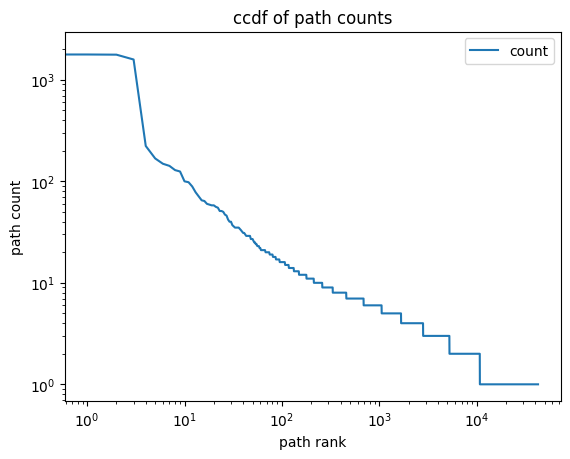

In [17]:
# Plot ccdf of path counts
import matplotlib.pyplot as plt
import numpy as np
plt.figure()
plt.plot(np.arange(len(by_path)), by_path['count'].values, label='count')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('path rank')
plt.ylabel('path count')
plt.title('ccdf of path counts')
plt.legend()

In [18]:
by_path = by_path[by_path["count"] > 10]
by_path

,start,end,count
0,Brain,Telephone,2044
1,Theatre,Zebra,1777
2,Asteroid,Viking,1770
3,Pyramid,Bean,1586
4,Batman,Wood,223
...,...,...,...
208,Barbados,Virus,11
209,ASCII,Swastika,11
210,Necktie,Lion,11
211,Euro,Whale,11


In [19]:
def get_links(article):
    """
    Get all links from a given article

    Args:
    article (str): article name

    Returns:
    list: list of articles linked to
    """
    return df_links[df_links.linkSource == article].linkTarget.values.tolist()

In [20]:
def llm_input(target, links):
    """
    Format input for LLM

    Args:
    target (str): target article
    links (list): list of articles linked to

    Returns:
    str: formatted input
    """

    return f"""

I will give you a target word and a list from which you can choose an option. If the available options contains the target word, you choose it. Otherwise you choose the option that is most similar to it    

Target word: [{target}]

Available options: [{links}]

RESPECT THIS FORMAT WHEN ANSWERING:

Reasoning: [REASONING]

Answer: Hence the choice is: '[ANSWER]' """
    
llm_input('George_Washington', ['Able_Archer_83', 'Afghanistan', 'Estonia', 'Europe', 'Finland', 'France', 'French_language', 'George_W._Bush', 'Hungary', 'September_11,_2001_attacks', 'United_States'])


"\n\nI will give you a target word and a list from which you can choose an option. If the available options contains the target word, you choose it. Otherwise you choose the option that is most similar to it    \n\nTarget word: [George_Washington]\n\nAvailable options: [['Able_Archer_83', 'Afghanistan', 'Estonia', 'Europe', 'Finland', 'France', 'French_language', 'George_W._Bush', 'Hungary', 'September_11,_2001_attacks', 'United_States']]\n\nRESPECT THIS FORMAT WHEN ANSWERING:\n\nReasoning: [REASONING]\n\nAnswer: Hence the choice is: '[ANSWER]' "

In [21]:
get_links('George_Washington')

['Abraham_Lincoln',
 'Alexander_Hamilton',
 'American_Revolutionary_War',
 'Church_of_England',
 'France',
 'Great_Lakes',
 'Hippopotamus',
 'John_Adams',
 'Lead',
 'Mount_Rushmore',
 'NATO',
 'New_York_City',
 'Pneumonia',
 'President_of_the_United_States',
 'Rhode_Island',
 'Supreme_Court_of_the_United_States',
 'Theodore_Roosevelt',
 'Thomas_Jefferson',
 'United_States',
 'United_States_Constitution',
 'West_Virginia']

In [22]:
response = client.chat(model='mistral', messages=[
            {
                'role': 'user',
                'content': """We now play the following game:

I will give you a target word and a list from which you can choose an option. If the available options contains the target word, you choose it. Otherwise you choose the option that is most similar to it. Before starting, I give you one examples, then it's your turn:

you need to follow the same format as the example below:
Target word: George_Washington

Available options: [Able_Archer_83, Afghanistan, , Estonia, Europe, Finland, France, French_language, George_W._Bush, Hungary, September_11,_2001_attacks, United_States]

Reasoning: I need to find something inside the list related to the target: 'George_Washington'. George Washington was the first president of United States and he lived in United States.

Answer: Hence the answer is: 'United_States'.
""",
            },
        ])

print(response['message']['content'])

 Target word: Shakespeare

Available options: [Sonnet, Hamlet, Macbeth, Romeo_and_Juliet, King_Lear, A Midsummer_Night's_Dream, Julius_Caesar, William_Shakespeare, The Tempest, Othello, The Globe]

Reasoning: Shakespeare is the author of many famous plays. Among the given options, the only one that directly relates to Shakespeare himself is 'William_Shakespeare'. However, since I am supposed to find something more general related to Shakespeare, I will choose his main profession and the most common thing associated with him, which is 'Plays' (in this case, Sonnet, Hamlet, Macbeth, Romeo_and_Juliet, King_Lear, A Midsummer_Night's_Dream, Julius_Caesar, The Tempest, Othello could all be considered as plays by Shakespeare). However, if 'Plays' is not an option in the list provided, then I would choose 'The Globe', since it refers to The Globe Theatre, where many of his works were performed.


In [ ]:
def llm_player(start, end):
    """
    Play the game of Wikispeedia

    Args:
    start (str): start article
    end (str): end article

    Returns:
    list: path taken
    """
    path = [start]
    current = start
    cpt = 0
    while current != end and cpt < 100:
        links = get_links(current)
        response = client.chat(model='mistral', messages=[
            {
                'role': 'user',
                'content': llm_input(end, links),
            }
        ],
            options={'temperature': 0.5}
            )
        answer = response['message']['content'].split('\n')[-1]
        for link in links:
            if link in answer:
                current = link
                path.append(current)
        cpt += 1

    if cpt == 100:
        print("No path found")
        return None
    return path


In [24]:
# for all start and end articles
llm_paths = []
for start, end in tqdm(by_path[['start', 'end']].values, total=len(by_path)):
    path = llm_player(start, end)
    llm_paths.append({'start': start, 'end': end, 'path': path})
df_llm_paths = pd.DataFrame(llm_paths)

  4%|▍         | 9/213 [02:19<52:39, 15.49s/it]  


KeyboardInterrupt: 

In [ ]:
df_llm_paths.head()

,start,end,path
0,Asteroid,Viking,"[Asteroid, Comet, Denmark, Viking]"


In [ ]:
df_llm_paths.to_csv('data/llm_paths.csv', index=False)

# Ideas of prompt:

- from AI vs human project:
`We now play the following game:

I will give you a target word and a list from which you can choose an option. If the list contains the target word, you choose it. Otherwise you choose the option that is most similar to it. Before starting, I give you one examples, then it's your turn:

EXAMPLE:
Target word: George_Washington

Available options: [[Able_Archer_83, Afghanistan, , Estonia, Europe, Finland, France, French_language, George_W._Bush, Hungary, September_11,_2001_attacks, United_States]]

Reasoning: I need to find something inside the list related to the target: 'George_Washington'. George Washington was the first president of United States and he lived in United States.

Answer: Hence the answer is: 'United_States'.

YOUR TURN:

Target word: {TARGET}

Available options: [[{LIST OF LINKS}]]

Reasoning: [REASONING]

Answer: Hence the choice is: '[ANSWER]'`


- ordering the options by order of appearence in text, to reproduce the fact that this is what humans see first.
`We now play the following game:

I will give you a target word and a list (in no specific order) from which you can choose an option. If the list contains the target word, you choose it. Otherwise you choose the option that is most similar to it. Before starting, I give you one examples, then it's your turn:

EXAMPLE:
Target word: George_Washington

Available options: [change]

Reasoning: I need to find something inside the list related to the target: 'George_Washington'. George Washington was the first president of United States and he lived in United States.

Answer: Hence the answer is: 'United_States'.

YOUR TURN:

Target word: {TARGET}

Available options: [[{LIST OF LINKS}]]

Reasoning: [REASONING]

Answer: Hence the choice is: '[ANSWER]'`



- explicit further the game 
`We now play the following game: I give you a target encyclopedia article, the current article you are in and the list of other article titles present in this current article. The final goal is to reach the target article as fast as possible by navigating from article to article. Your task right now is to choose an article from the list I give you that brings you closer to the target. If the target is present in the list, return the target.
Before starting, I give you one examples, then it's your turn:

EXAMPLE:
Target word: George_Washington

Available options: [change]

Reasoning: I need to find something inside the list related to the target: 'George_Washington'. George Washington was the first president of United States and he lived in United States.

Answer: Hence the answer is: 'United_States'.

YOUR TURN:

Target word: {TARGET}

Available options: [[{LIST OF LINKS}]]

Reasoning: [REASONING]

Answer: Hence the choice is: '[ANSWER]'`